In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def generate_random_bits(n):
    return np.random.choice([-1, 1], size=n)

def transmit_data(data, channel, noise_power):
    # Ensure data and channel have the same length
    min_length = min(len(data), len(channel))
    data = data[:min_length]
    channel = channel[:min_length]
    
    signal_power = np.mean((channel*data) ** 2)
    noise = np.sqrt(signal_power * noise_power/2) * (np.random.randn(min_length) + 1j * np.random.randn(min_length))
    return channel * data + noise

def estimate_channel(received, data):
    # Ensure both received and data have the same length
    min_length = min(len(received), len(data))
    received = received[:min_length]
    data = data[:min_length]
    
    # Use pseudoinverse to handle potential rank deficiency
    return np.linalg.pinv(np.diag(data)) @ received

def predict_channel_var(channel_history, steps):
    # Convert input to numpy array and reshape to ensure 2D column array
    channel_history = np.array(channel_history).reshape(-1, 1)
    # Separate real and imaginary parts
    channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
    # If not enough samples for VAR model, repeat the last value
    if len(channel_history_separated) < var_order:
        return np.tile(channel_history[-1], steps)
    model = VAR(channel_history_separated)
    results = model.fit(var_order, trend = 'n')
    forecast = results.forecast(channel_history_separated[-var_order:], steps=steps)
    return forecast[:, 0] + 1j * forecast[:, 1]

In [3]:
def jakes_sos(P, K, Fs, Fd, N, typ='comp'):
    t = np.linspace(0, P/Fs, P)
    omega_d = 2 * np.pi * Fd
    
    # Initialize jakes_rvs to store real or complex numbers
    jakes_rvs = np.zeros((K, P), dtype=complex)
    
    for k in range(K):
        alpha = np.random.uniform(0, 2 * np.pi, N)
        alpha_m = np.array([((2 * np.pi * n) - np.pi + al)/(4*N) for n, al in enumerate(alpha)])
        a_m = np.random.uniform(0, 2 * np.pi, N)
        b_m = np.random.uniform(0, 2 * np.pi, N)
        
        cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
        real_part = np.sqrt(1/N) * np.sum(cosine_terms, axis=1)
        
        if typ == 'comp':
            sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
            imag_part = np.sqrt(1/N) * np.sum(sine_terms, axis=1)
            jakes_rvs[k] = real_part + 1j * imag_part
        else:
            jakes_rvs[k] = real_part + 1j * 0
    
    return jakes_rvs

def generate_channels_for_doppler_frequencies(doppler_frequencies, sampling_frequency=100000, num_samples=100000):
    for Fd in doppler_frequencies:
        # Generate Jakes random variables
        jakes_rvs = jakes_sos(num_samples, 1, sampling_frequency, Fd, 100, 'comp')
        
        # Flatten the channel values
        channel_vals = jakes_rvs.flatten()
        
        # Create filename based on Doppler frequency
        filename = f"channel_Fd_{Fd}Hz.txt"
        
        # Write channels to file
        with open(filename, "w") as fo:
            for sample in channel_vals:
                # Write complex number as [real, imag]
                json.dump([sample.real, sample.imag], fo)
                fo.write('\n')
        #print("Channel generated for:", Fd, "Hz")
                
def load_channel_values(filename):
    with open(filename, 'r') as fi:
        channel_vals = []
        for line in fi:
            # Parse JSON line as complex number
            real, imag = json.loads(line)
            channel_vals.append(complex(real, imag))
    return np.array(channel_vals)


In [4]:
# Parameters
packet_size = 1
pilot_size = 100  # Full packet size for initial fit and refits
var_order = 25
mse_threshold = 0.01

In [5]:
def autoreg_simulate(Fd, Fs, mse_threshold, N, SNR):
    noise_power = 10**(-SNR / 10)
    generate_channels_for_doppler_frequencies([Fd], sampling_frequency=Fs, num_samples=N)
    filename = f"channel_Fd_{Fd}Hz.txt"
    #channel_vals contains the actual channel values which we have no realistic way of knowing
    channel_vals = load_channel_values(filename)
    # Ensure we have enough samples
    if len(channel_vals) < N:
        print(f"Warning: Not enough channel samples. Required: {N}, Available: {len(channel_vals)}")
        return None, None
    
    # Initialize tracking variables
    refit_counts = 0        
    current_index = 0
    total_packets = 0
    wrong_packets = 0
    all_predictions = []
    
    # Send pilot bits
    pilot_bits = generate_random_bits(pilot_size)
    actual_channel = channel_vals[current_index:current_index+pilot_size]
    current_index += pilot_size
    received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
    # Estimate channel from pilot bits
    estimated_channel = estimate_channel(received_pilot, pilot_bits)
    # Update predictions 
    all_predictions.extend(estimated_channel)
    
    # Main simulation loop
    while current_index < N - packet_size:
        # Generate data bits
        data_bits = generate_random_bits(packet_size)
        actual_channel = channel_vals[current_index:current_index + packet_size]
        # Predict channel using VAR model
        predicted_channel = predict_channel_var(all_predictions[-pilot_size:], packet_size)
        # Transmit data
        received_data = transmit_data(data_bits, actual_channel, noise_power)
        # Estimate data bits
        estimated_data_bits = np.sign(np.real(received_data * predicted_channel.conjugate() / (abs(predicted_channel))**2))
        # Estimate channel
        estimated_channel = estimate_channel(received_data, estimated_data_bits)
        # Compute MSE
        mse = np.mean(np.abs(estimated_channel - predicted_channel)**2)
        
        if mse > mse_threshold:
            # Retransmission needed
            refit_counts += 1
            pilot_bits = generate_random_bits(pilot_size)
            actual_channel = channel_vals[current_index:current_index + pilot_size]
            current_index += pilot_size
            received_pilot = transmit_data(pilot_bits, actual_channel, noise_power)
            estimated_channel = estimate_channel(received_pilot, pilot_bits)
            #all_predictions.extend(estimated_channel)
            all_predictions = np.concatenate([all_predictions, estimated_channel])
        else:
            #all_predictions.extend(predicted_channel)
            all_predictions = np.concatenate([all_predictions, predicted_channel])
            total_packets += packet_size
            for i in range(packet_size):
                if estimated_data_bits[i] != data_bits[i]:
                    wrong_packets += 1
            current_index += packet_size
        
        if current_index >= N:
            break
    # Compute retransmission frequency and bit error rate
    retrans_frequency = np.float16(refit_counts * pilot_size / (N))
    ber = np.float16(wrong_packets / total_packets) if total_packets > 0 else 0
    
    return retrans_frequency, ber

In [6]:
Fs = 10000
retrans_frequency, ber = autoreg_simulate(0, Fs, 0.1, 1000, 10)
print(retrans_frequency)
print(ber)

0.9
0.01136


In [7]:
def packetwise_simulate(Fd, Fs, mse_threshold, N, SNR):
    noise_power = 10**(-SNR / 10)
    # Generate channels appropriately
    generate_channels_for_doppler_frequencies([Fd], sampling_frequency=Fs, num_samples=N)
    filename = f"channel_Fd_{Fd}Hz.txt"
    # Load channel values
    channel_vals = load_channel_values(filename)
    
    # Initialize some values       
    current_index = 0
    total_packets = 0
    wrong_packets = 0
    actual_channels = []
    
    # Here the packets are composed of a 1 bit pilot and 3 bit data-packet
    while current_index < N - 4:  # Ensure enough channel values remain
        # Pilot bit transmission
        pilot_bit = generate_random_bits(1)
        actual_channel = channel_vals[current_index:current_index + 1]
        actual_channels.append(actual_channel[0])  # Store the single channel value
        received_pilot = transmit_data(pilot_bit, actual_channel, noise_power)
        estimated_channel = estimate_channel(received_pilot, pilot_bit)
        
        # Move index forward
        current_index += 1
        
        # Data packet transmission
        data_bits = generate_random_bits(3)
        
        # Ensure we have enough channel values
        if current_index + 3 >= len(channel_vals):
            break
        
        # Use consecutive channel values for data transmission
        actual_channel = channel_vals[current_index:current_index + 3]
        received_data = transmit_data(data_bits, actual_channel, noise_power)
        
        # Estimate data bits
        estimated_data_bits = np.sign(np.real(received_data * estimated_channel.conjugate() / (abs(estimated_channel))**2))
        
        # Update packet statistics
        total_packets += 3
        for i in range(3):
            if data_bits[i] != estimated_data_bits[i]:
                wrong_packets += 1
        
        # Move index forward
        current_index += 3
    
    # Calculate Bit Error Rate
    if total_packets == 0:
        return None
    else:
        return np.float16(wrong_packets / total_packets)

In [8]:
packetwise_simulate(100, 100000, 0.1, 100000, 10)

2.664e-05

# Testing the prediction algorithm for a specific Doppler Frequency

In [10]:
Fs = 100000
retrans_frequency, ber = autoreg_simulate(0, Fs, 0.1, 100000, 10)
print(retrans_frequency)
print(ber)

0.995
0.0


In [11]:
#Try for 100Hz
ber = packetwise_simulate(100, 100000, 0.1, 100000, 10)
print(ber)

8e-05


# Plotting out retransmission frequency against Doppler frequency

In [13]:
pilot_size = 50
packet_size = 1
var_order = 25 #order of the VAR we use
N = 10000
mse_threshold = 0.1
SNR = 10 
Fs = 100000 
doppler_frequencies = np.linspace(0, 1700, 150)  
retrans_frequencies = []
ber_values = []
for Fd in doppler_frequencies:
    retrans_frequency = 0
    ber = 0
    for i in range(3):
        retrans_frequency1, ber1 = autoreg_simulate(Fd, Fs, mse_threshold, N, SNR)
        retrans_frequency += retrans_frequency1
        ber += ber1
    retrans_frequencies.append(retrans_frequency/3)
    ber_values.append(ber/3)

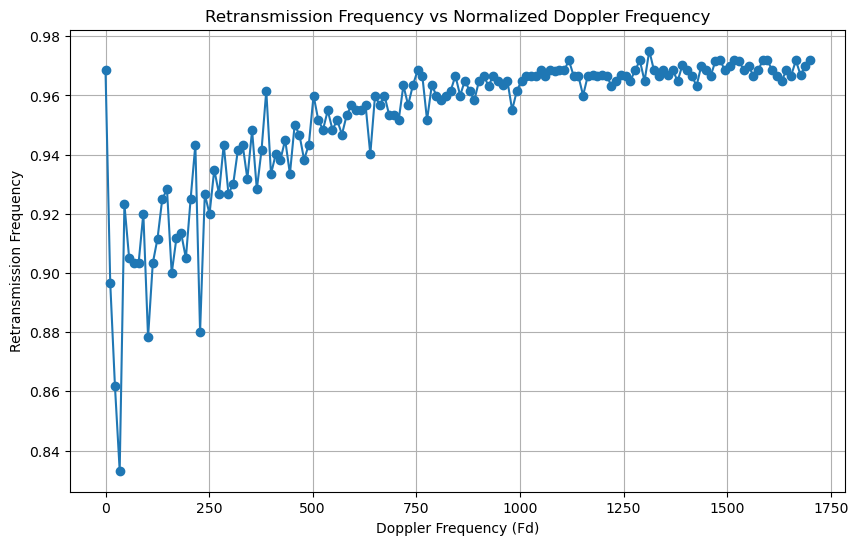

In [14]:
#Plot retransmission frequency vs normalized Doppler frequency
plt.figure(figsize=(10, 6))
plt.plot(doppler_frequencies, retrans_frequencies, 'o-', label='Retransmission Frequency')
plt.xlabel('Doppler Frequency (Fd)')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Normalized Doppler Frequency')
plt.grid(True)
plt.show()

# Plotting retransmission frequency against Doppler frequency for different thresholds

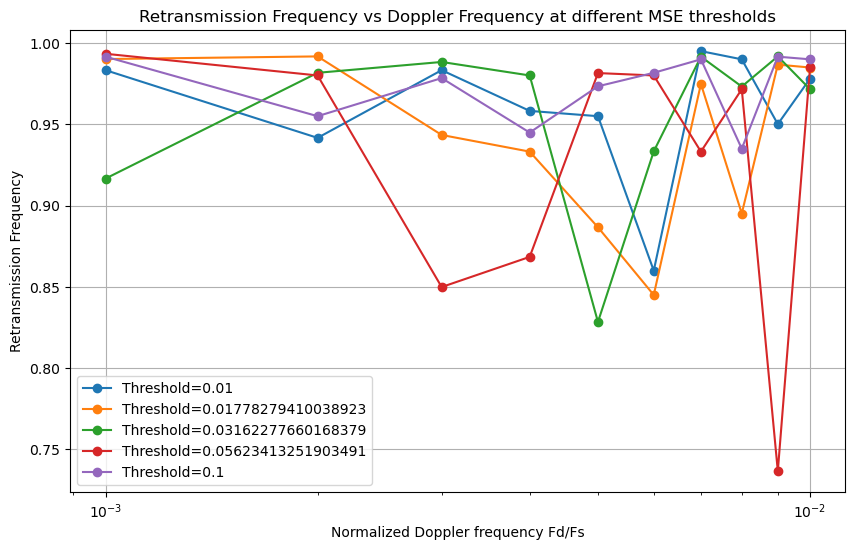

In [16]:
thresholds = np.logspace(-2, -1, 5)  # MSE thresholds
selected_dopplers = [100/Fs, 200/Fs, 300/Fs, 400/Fs, 500/Fs, 600/Fs, 700/Fs, 800/Fs, 900/Fs, 1000/Fs]
retrans_frequencies_dict = {thresh: [] for thresh in thresholds}
pilot_size = 50 
var_order = 20 #order of the VAR we use
N = 10000
mse_threshold = 0.1
SNR = 10 
Fs = 100000 
for threshold in thresholds:
    for Fd in selected_dopplers:
        retrans_freq = 0
        for i in range(3):
            retrans_frequency1, ber1 = autoreg_simulate(Fd, Fs, mse_threshold, N, SNR)
            retrans_freq += retrans_frequency1
        retrans_frequencies_dict[threshold].append(retrans_freq/3)
    
# Plot average retransmission frequency vs MSE threshold
plt.figure(figsize=(10, 6))
for thresh, avg_freqs in retrans_frequencies_dict.items():
    plt.semilogx(selected_dopplers, avg_freqs, 'o-', label=f'Threshold={thresh}')
plt.xlabel('Normalized Doppler frequency Fd/Fs')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Doppler Frequency at different MSE thresholds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting BER against SNR for the 2 channel estimation approaches we have

In [19]:
snr_db= [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16]

pilot_size = 50 
var_order = 20 #order of the VAR we use
N = 10000
mse_threshold = 0.1
SNR = 10 
Fs = 100000 
Fd = 100
ber_autoreg = []
ber_packetwise = []
for snr in snr_db:
    ber1 = 0
    ber2 = 0
    for i in range(3):
        _, ber11 = autoreg_simulate(Fd, Fs, mse_threshold, N, snr)
        ber21 = packetwise_simulate(Fd, Fs, mse_threshold, N, snr)
        ber1 += ber11
        ber2 += ber21
    ber_autoreg.append(ber1/3) 
    ber_packetwise.append(ber2/3)

NameError: name 'ticker' is not defined

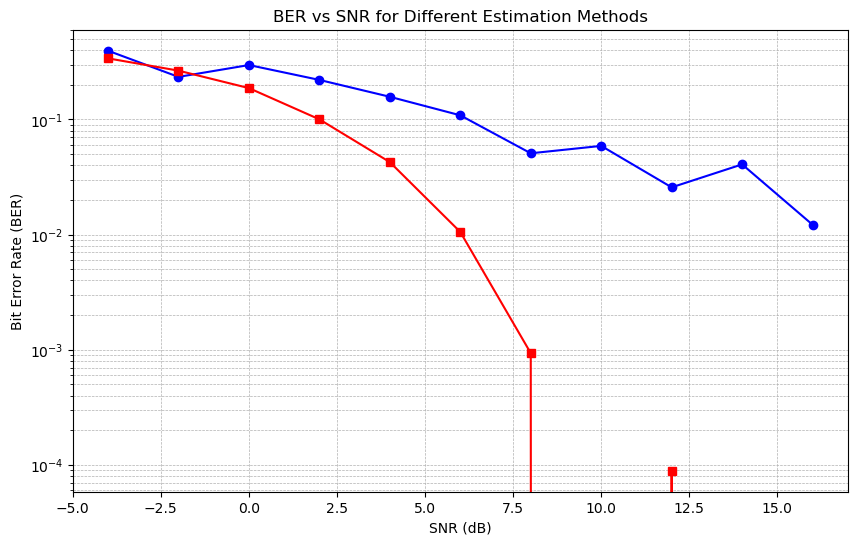

In [20]:
# Plotting both methods on the same figure
plt.figure(figsize=(10, 6))

# Plot autoregressive method BER
plt.semilogy(snr_db, ber_autoreg, marker='o', label='Autoregressive Method', color='blue')

# Plot packetwise method BER
plt.semilogy(snr_db, ber_packetwise, marker='s', label='Packetwise Method', color='red')

# Formatting
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for Different Estimation Methods')

# Adjust y-axis ticks
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=12))

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()